# MA3315: Introduction to Visual Computing
## Assignment 1

This assignment has two problems. 

Let us load the required libraries first. 

In [1]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values &mdash; $0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{2}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

def gaussian_smoothing(img):
    return gaussian_filter(img,1)
    
def gradient(smoothed):
    
    Sy = np.array([[-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]])
    Sx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
    
    gx = convolve2d(smoothed,Sx,mode = "same")
    gy = convolve2d(smoothed,Sy,mode = "same")    
    
    g_dir = np.zeros_like(gx).astype(float)
    g_dir[(gy != 0 )* gx != 0] = np.arctan(gy[(gy!=0 )* gx != 0]/gx[(gy!=0 )* gx != 0])
    g_dir[(gx == 0) * gy != 0] = np.pi 
        
    return np.sqrt(gx**2+gy**2), g_dir
    
def dec(g,theta):
    n,p = g.shape
    if theta == 0:
        return np.hstack((g,np.zeros((n,1))))[:,1:],np.hstack((np.zeros((n,1)),g))[:,:-1]
    if theta == np.pi/2 or theta == -np.pi/2:
        return np.vstack((g,np.zeros((1,p))))[1:,],np.vstack((np.zeros((1,p)),g))[:-1,:]
    if theta == np.pi/4:
        s1 = np.hstack((g,np.zeros((n,1))))
        s2 = np.hstack((np.zeros((n,1)),g))
        return np.vstack((np.zeros((1,p+1)),s1))[:-1,1:], np.vstack((s2,np.zeros((1,p+1))))[1:,:-1]
        
def non_maximum_suppression(g_magnitude, g_dir):
    
    def quantise(dirs,angles):
        res = np.zeros_like(dirs).astype(float)
        angles = np.sort(angles)
        for i, theta in enumerate(angles[:-1]):
            med = (theta + angles[i+1])/2
            res[(dirs >= theta)*(dirs < med)] = theta
        res[dirs >= med] = angles[-1]
        return res
    
    n,p = g_magnitude.shape
    res = g_magnitude + 0
    angles = [-np.pi/2,0,np.pi/4,np.pi/2]
    g_quant = quantise(g_dir,angles)

    for theta in angles:
        gv1,gv2 = dec(g_magnitude,theta)
        res[(g_magnitude < gv1) * (g_quant == theta)] = 0
        res[(g_magnitude < gv2) * (g_quant == theta)] = 0
    return res

'''
def non_maximum_suppression2(g_magnitude, g_dir):
    
    def quantise(dirs,angles):
        res = np.zeros_like(dirs).astype(float)
        angles = np.sort(angles)
        for i, theta in enumerate(angles[:-1]):
            med = (theta + angles[i+1])/2
            res[(dirs >= theta)*(dirs < med)] = theta
        res[dirs >= med] = angles[-1]
        return res
    g_quant = quantise(g_dir,[-np.pi/2,0,np.pi/4,np.pi/2])
    
    n,p = g_magnitude.shape
    
    res = g_magnitude + 0
    for i in range(1,n-1):
        for j in range(1,p-1):
            if g_quant[i,j] == np.pi/2 or g_quant[i,j] == -np.pi/2:
                if g_magnitude[i,j] < g_magnitude[i+1,j] or g_magnitude[i,j] < g_magnitude[i-1,j]:
                    res[i,j] = 0
            if g_quant[i,j] == 0:
                if g_magnitude[i,j] < g_magnitude[i,j+1] or g_magnitude[i,j] < g_magnitude[i,j-1]:
                    res[i,j] = 0
            if g_quant[i,j] == np.pi/4:
                if g_magnitude[i,j] < g_magnitude[i+1,j-1] or g_magnitude[i,j] < g_magnitude[i-1,j+1]:
                    res[i,j] = 0
    
    for i in range(n):
        if g_quant[i,0] == -np.pi/2 or g_quant[i,0] == np.pi/2:
            if i > 0:
                if g_magnitude[i,0] < g_magnitude[i-1,0]:
                    res[i,0] = 0
            if i < n-1:
                if g_magnitude[i,0] < g_magnitude[i+1,0]:
                    res[i,0] = 0
        if g_quant[i,-1] == -np.pi/2 or g_quant[i,-1] == np.pi/2:
            if i > 0:
                if g_magnitude[i,-1] < g_magnitude[i-1,-1]:
                    res[i,-1] = 0
            if i < n-1:
                if g_magnitude[i,-1] < g_magnitude[i+1,-1]:
                    res[i,-1] = 0                    
                    
        if g_quant[i,0] == 0:
            if g_magnitude[i,0] < g_magnitude[i,1]:
                res[i,0] = 0
        if g_quant[i,-1] == 0:    
            if g_magnitude[i,-1] < g_magnitude[i,-2]:
                res[i,-1] = 0
        
        if g_quant[i,0] == -np.pi/4:
            if i > 0 and g_magnitude[i,0] < g_magnitude[i-1,1]:
                res[i,0] = 0
        if g_quant[i,-1] == -np.pi/4:
            if i < n-1 and  g_magnitude[i,-1] < g_magnitude[i+1,-2]:
                res[i,-1] = 0
                    
    for j in range(p):
        if g_quant[0,j] == 0:
            if j > 0:
                if g_magnitude[0,j] < g_magnitude[0,j-1]:
                    res[0,j] = 0
            if j < p-1:
                if g_magnitude[0,j] < g_magnitude[0,j+1]:
                    res[0,j] = 0
        if g_quant[-1,j] == 0:
            if j > 0:
                if g_magnitude[-1,j] < g_magnitude[-1,j-1]:
                    res[-1,j] = 0
            if j < p-1:
                if g_magnitude[-1,j] < g_magnitude[-1,j+1]:
                    res[-1,j] = 0
                    
        if g_quant[0,j] == -np.pi/2 or g_quant[0,j] == np.pi/2:
            if g_magnitude[0,j] < g_magnitude[1,j]:
                res[0,j] = 0
        if g_quant[-1,j] == -np.pi/2 or g_quant[-1,j] == np.pi/2:
            if g_magnitude[-1,j] < g_magnitude[-2,j]:
                res[-1,j] = 0
        
        if g_quant[0,j] == -np.pi/4:
            if j > 0 and g_magnitude[0,j] < g_magnitude[1,j-1]:
                res[0,j] = 0
        if g_quant[-1,j] == -np.pi/4:
            if j < p-1 and g_magnitude[-1,j] < g_magnitude[-2,j+1]:
                res[-1,j] = 0
                
            
    return res
'''

def double_thresholding(g_max,thresh_lo,thresh_hi):
    
    gmx = g_max.max()
    thrlo = gmx*thresh_lo
    thrhi = gmx*thresh_hi
    
    res = np.zeros_like(g_max)
    res[g_max > thrlo] = 1
    res[g_max > thrhi] = 2
    
    return res

def connectivity(thresh_img):
    
    res = np.zeros_like(thresh_img)
    res[thresh_img == 2] = 1

    gv11,gv12 = dec(thresh_img, np.pi/2)
    gv21,gv22 = dec(thresh_img,0)
    res[(thresh_img == 1) * ((gv11 == 2 )+( gv12 == 2) + (gv21 == 2 )+ (gv22 == 2))] = 1
    return res
                            
    

In [3]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max,thresh_lo,thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

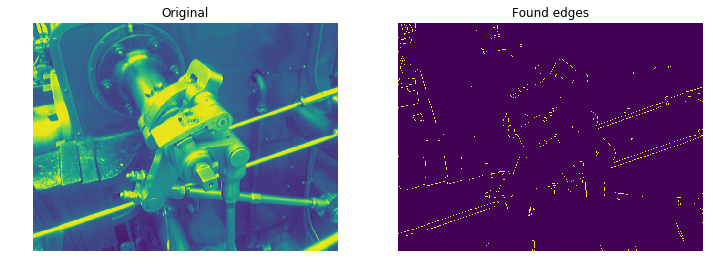

In [4]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = canny_edge_detector(img)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

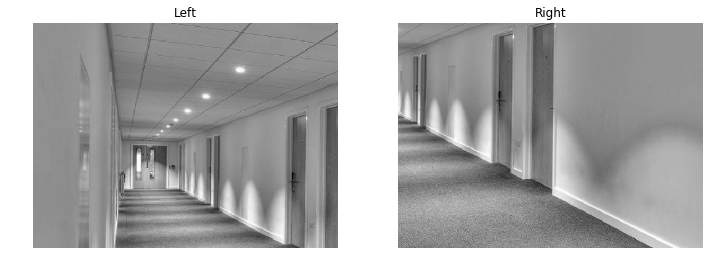

In [5]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [6]:
#This function adds zeros to a 2d array in both dimensions to compute easily the borders
def paddle(g,u,v):
    n,p = g.shape
    res = np.hstack((np.zeros((n,v)),g,np.zeros((n,v))))
    res = np.vstack((np.zeros((u,p+2*v)),res,np.zeros((u,p+2*v))))
    return res

#This function computes the harris detectors for each pixel
def harris(img,window_size):
    
    Sy = np.array([[-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]])
    Sx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
    
    u,v = window_size
    n,p = img.shape
    
    Ix = convolve2d(img,Sx,mode = "same")
    Iy = convolve2d(img,Sy,mode = "same")
    
    Ix = paddle(Ix,u,v)
    Iy = paddle(Iy,u,v)

    res = np.zeros_like(img).astype(float)
    for i in range(u,u+n):
        for j in range(v,v+p):
            trace = (Ix[i-u:i+u,j-v:j+v]**2).sum() + (Iy[i-u:i+u,j-v:j+v]**2).sum()
            det =  (Ix[i-u:i+u,j-v:j+v]**2).sum() * (Iy[i-u:i+u,j-v:j+v]**2).sum() - \
                (Ix[i-u:i+u,j-v:j+v]*Ix[i-u:i+u,j-v:j+v]).sum()**2 
            
            res[i-u,j-v] = det - 0.04* trace**2
    return res
    
#This function decides which harris detectors are corners
def harris_corner_detector(img):
    h = harris(img,(2,2))
    #h = cv2.cornerHarris(img,2,3,0.04)
    return np.where(h > 0.05*h.max())

#This function returns a random pair of corners
def find_random_pair(corners_left,corners_right):
    cl = np.random.randint(0,corners_left[0].shape[0])
    cr = np.random.randint(0,corners_right[0].shape[0])
    return np.array([corners_left[0][cl],corners_left[1][cl]]) , np.array([corners_right[0][cr],corners_right[1][cr]])

def find_translation_vector(c_left,c_right):
    return c_right-c_left

#This function aligns two images depending on the translation vector linking them
def translate(img1,img2,xt,yt):
    if xt < 0: 
        res2 = np.hstack((-1+np.zeros((img2.shape[0],-xt)),img2))
        res1 = img1 #res1 = np.hstack((img1,-1+np.zeros((img1.shape[0],-xt))))
    else: 
        res1 = np.hstack((-1+np.zeros((img1.shape[0],xt)),img1)) 
        res2 = img2#res2 = np.hstack((img2,-1+np.zeros((img2.shape[0],max(res1.shape[0]+abs(xt)-img2.shape[0],0)))))
    if yt < 0: 
        res2 = np.vstack((-1+np.zeros((-yt,res2.shape[1])),res2))
        #res1 = np.vstack((res1,-1+np.zeros((-yt,res1.shape[1]))))
    else: 
        res1 = np.vstack((-1+np.zeros((yt,res1.shape[1])),res1))
        #res2 = np.vstack((res2,-1+np.zeros((yt,res2.shape[1]))))
    return res1,res2

#This function increases the dimensions a 2d array by filling by -1  
def fill(a,n,p):
    na,pa = a.shape
    res = a + 0
    if n > na: res = np.vstack((a,-1+np.zeros((n-na,res.shape[1]))))
    if p > pa: res = np.hstack((res,-1+np.zeros((res.shape[0],p-pa))))
    return res

#This function translates the two images in the same space to be compared easily
def create_images_match(left_img,right_img,xt,yt):
    left_t,right_t = translate(left_img,right_img,xt,yt)
    n,p = np.maximum(left_t.shape,right_t.shape)
    left_t = fill(left_t,n,p)
    right_t = fill(right_t,n,p)
    return left_t,right_t

#This function computes the overlapping between the two images we want to stitch
def overlap(img1,img2):
    res2 = img2
    res2[img1 == -1] = -1
    res1 = img1
    res1[img2 == -1] = -1
    return res1,res2
        
#This function computes the similarities between the overlapped zones
def compute_error(left_img,right_img,xt,yt):
    left_t,right_t = create_images_match(left_img,right_img,xt,yt)
    ov1,ov2 = overlap(left_t,right_t)
    ov_size = np.sum(ov1 != -1)
    if ov_size: return np.linalg.norm(ov1-ov2)/ov_size
    else: return np.inf

#This function fuses the two images into one
def match(left_img,right_img,xt,yt):
    left_t,right_t = create_images_match(left_img,right_img,xt,yt)
    toadd = right_t
    toadd[left_t != -1] = 0
    matched = left_t + toadd
    return matched

In [7]:
def stitch_images(left, right, max_tries=1000):
    # Find corner points
    corners_left  = harris_corner_detector(left)
    corners_right = harris_corner_detector(right)
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    best_corners = None
    errors = np.zeros((max_tries,5))

    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error. 
        this_error       = compute_error(left_img,right_img,y_trans,x_trans )
        errors[n_try] = np.concatenate((c_left,c_right,np.array([this_error])))
        
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
            best_corners = (c_left,c_right)
            
    stitched_image = match(left,right,best_trans[1],best_trans[0])
    return stitched_image,np.array(errors),best_trans, best_error

23.927575826644897


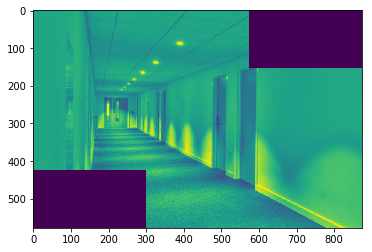

In [8]:
t1 = time()
matched,errors,best_trans,best_error = stitch_images(left_img,right_img,max_tries = 1000)
print(time()-t1)
plt.imshow(matched)

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

When we correspond the harris detectors, instead of defining a translation vector, we define an affine matrix and rotation matrix. For this we use 3 pairs of points.